# \begin{aligned}  \textbf{ Language modelling and byte-pair encoding } 
\end{aligned} 



## Import necessary library

In [128]:
import pandas as pd
import numpy as np
import re
import unicodedata
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) Dataset

#### TRAIN DATASET

In [129]:
# Read the training data for each language
training_files = {
    'af': 'data/train.af.txt',
    'nl': 'data/train.nl.txt',
    'en': 'data/train.en.txt',
    'xh': 'data/train.xh.txt',
    'zu': 'data/train.zu.txt' }

training_data = {}
for lang, file_path in training_files.items():
    df_t = pd.read_csv(file_path, delimiter='\t', header=None)
    df_t = df_t.rename(columns={0: 'sentences'})  # Rename the column to 'sentence'
    training_data[lang] = df_t
    
print(training_data['af']) 

                                              sentences
0                                                Afrika
1                                                Afrika
2     Afrika is die wêreld se tweede grootste kontin...
3                                                 Tale.
4     Die meeste amptelike tale van Afrika is Indo-E...
...                                                 ...
1995  In die vroeë 17de eeu was Galileo 'n baanbreke...
1996  Van die 18de eeu af is termodinamika deur Boyl...
1997  Die gedrag van elektrisiteit en magnetisme is ...
1998  In 1895 het Röntgen X-strale ontdek wat later ...
1999  In 1897 het Thomson die elektron, die elementê...

[2000 rows x 1 columns]


#### VALIDATION DATASET

In [130]:
# Read the validation data for each language
val_files = {
    'af': 'data/val.af.txt',
    'nl': 'data/val.nl.txt',
    'en': 'data/val.en.txt',
    'xh': 'data/val.xh.txt',
    'zu': 'data/val.zu.txt' }

val_datas = {}
for lang, file_path in val_files.items():
    df_v = pd.read_csv(file_path, delimiter='\t', header=None)
    df_v = df_v.rename(columns={0: 'sentences'})  # Rename the column to 'sentence'
    val_datas[lang] = df_v
    
print(val_datas['en']) 

                                             sentences
0    modal dispersion can be further decreased by s...
1                              mechanical or physical 
2    when a fault or event occurs a network compone...
3    a recent addition to the soa family is the ver...
4    in order that the freedom of this commonwealth...
..                                                 ...
995  this triple repetition code is a hamming code ...
996  afsk is not always used for highspeed data com...
997                                      silent films 
998  for a periodic signal a frequency component is...
999  network attached storage removes the responsib...

[1000 rows x 1 columns]


#### TEST DATASET

In [131]:
# Read the test data into a DataFrame
test_data = pd.read_csv('data/test.lid.txt', delimiter='\t',header=None)
print(test_data)

                                                     0
0    zu encwadini kamormoni ithi ngokuba bheka inin...
1                                          zu umbhalo 
2    af op daardie stadium het die n 0 deur die gro...
3                                       nl zuidafrika 
4                                af n 0 nasionale pad 
..                                                 ...
995  xh ngomqondiso ababese bewuqukumbele bawuthi j...
996  zu ukungezwani okuthile okuphawuleka ngobukres...
997  zu izibonelo eziqavile zalokhu zihlanganisa um...
998  nl in 0000 was sammy monsels tankbestuurder ge...
999  en the usual dotmatrix printer support for con...

[1000 rows x 1 columns]


In [132]:
# Create a new column 'label' using the first two letters of each line
test_data['labels'] = test_data[0].apply(lambda x: x[:2])

# Remove the label from the beginning of each sentence
test_data[0] = test_data[0].str[2:]

# Rename the first column to 'sentence'
test_data = test_data.rename(columns={0: 'sentences'})

print(test_data)

                                             sentences labels
0     encwadini kamormoni ithi ngokuba bheka iningi...     zu
1                                             umbhalo      zu
2     op daardie stadium het die n 0 deur die groot...     af
3                                          zuidafrika      nl
4                                   n 0 nasionale pad      af
..                                                 ...    ...
995   ngomqondiso ababese bewuqukumbele bawuthi jwi...     xh
996   ukungezwani okuthile okuphawuleka ngobukrestu...     zu
997   izibonelo eziqavile zalokhu zihlanganisa umhl...     zu
998   in 0000 was sammy monsels tankbestuurder gewo...     nl
999   the usual dotmatrix printer support for conti...     en

[1000 rows x 2 columns]


# 2) Text normalization


To normalize the training data to match the form of the validation and test data, several text normalization steps need to be performed. Here's code with different  steps:

In [133]:
#### Dealing with Diacritics
def remove_diacritics(text):
    normalized_text = unicodedata.normalize('NFKD', text)
    normalized_text = ''.join(c for c in normalized_text if not unicodedata.combining(c))
    return normalized_text

#### Dealing with Digits
def replace_digits(text):
    normalized_text = re.sub(r'\d', '0', text)
    return normalized_text

#### Dealing with Punctuation
def deal_punctuation(text):
    # Remove quotation marks
    text = text.replace('"', '')
    text = text.replace("'", '')
    
    # Remove commas
    text = text.replace(',', '')
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # remove non-alphabetic characters 
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) 
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def normalize_text(text):
    # Step 1: Splitting Paragraphs into Sentences
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', text)
    
    normalized_sentences = []
    for sentence in sentences:
        # Step 2: Dealing with Diacritics
        normalized_sentence = remove_diacritics(sentence)
        
        # Step 3: Dealing with Digits
        normalized_sentence = replace_digits(normalized_sentence)
        
        # Step 4: Dealing with Punctuation
        normalized_sentence = deal_punctuation(normalized_sentence)
        
        normalized_sentences.append(normalized_sentence)
    
    return normalized_sentences

        
for lang, file_path in training_files.items():
    df = pd.read_csv(file_path, delimiter='\t', header=None)
    training_data[lang] = df
        

# Normalize the training data
normalized_training_data = {}
for lang, data in training_data.items():
    normalized_sentences = []
    line_numbers = []
    for i, row in data.iterrows():
        sentences = normalize_text(row[0])
        normalized_sentences.extend(sentences)
        line_numbers.extend([i] * len(sentences))
    df_normalized = pd.DataFrame({'Initial Lines': line_numbers, 'Sentence': normalized_sentences})
    normalized_training_data[lang] = df_normalized
    
# Example usage
print(normalized_training_data['nl'])

      Initial Lines                                           Sentence
0                 0                                       albert speer
1                 1  berthold konrad hermann albert speer mannheim ...
2                 1  tijdens de naziheerschappij over duitsland 000...
3                 1  door zijn vriendschap met adolf hitler en zijn...
4                 1  na de oorlog werd speer in neurenberg veroorde...
...             ...                                                ...
5463           1996  op verschillende plekken in de stad markeren m...
5464           1997  de rechtbank gelderland en het gerechtshof arn...
5465           1997  daarnaast is de stad standplaats van een aanta...
5466           1998                                 etymologie en taal
5467           1999  de naam arnhem zou afgeleid zijn van arn of ar...

[5468 rows x 2 columns]


In this code , the **normalize_text** function takes a paragraph of text as input and performs the text normalization steps. The **remove_diacritics** function uses Unicode normalization to remove diacritics from the text. The **replace_digits** function replaces all digits by 0. The **normalize_punctuation** function converts the text to lowercase to normalize capitalization, remove quotation marks, comma, punctuations, non-alphabetic characters  and extra whitespace. We can see that the number of rows increase after normalization. That's normal because when splitting paragraph into sentences, a line for example which has 5 sentences merged in one paragraph will become 5 lines and so on. On the output we can see the initial number of rows and the final one for each language, while observing all the rows that have been multiplied. And down we can find the representation with only the new number of rows.

We don't even expect to have the same number of new rows for each language train set because they are different.

In [134]:
# Normalize the training data
normalized_training_data = {}
for lang, data in training_data.items():
    normalized_sentences = []
    for _, row in data.iterrows():
        normalized_sentences.extend(normalize_text(row[0]))
    df_normalized = pd.DataFrame({'Sentence': normalized_sentences})
    normalized_training_data[lang] = df_normalized

# Example usage
print(normalized_training_data['af'])

                                               Sentence
0                                                afrika
1                                                afrika
2     afrika is die wereld se tweede grootste kontin...
3     saam met die eilande beslaan dit ongeveer 00 0...
4                                                  tale
...                                                 ...
5640  in 0000 het rontgen xstrale ontdek wat later g...
5641  radioaktiwiteit is in 0000 deur henri becquere...
5642       dit het die vakgebied van kernfisika ingelui
5643  in 0000 het thomson die elektron die elementer...
5644  in 0000 het hy die eerste model van die atoom ...

[5645 rows x 1 columns]


# 3) Language modelling



##  Train character-level trigram language models and generate output

Here we use the training data to estimate the probabilities of each trigram (sequence of three characters) occurring in the language and utilize these probabilities  to generate new sequences of characters. Here's the code to train character-level trigram language models for each language and generate output from the language models:

In [147]:
# Function to train a trigram language model for a given language
def train_language_model(text):
    trigrams = {}
    historys = {}
    total_count = 0

    # Count occurrences of trigrams and historys
    for i in range(len(text) - 2):
        trigram = text[i:i+3]
        history = trigram[:2]

        if trigram in trigrams:
            trigrams[trigram] += 1
        else:
            trigrams[trigram] = 1

        if history in historys:
            historys[history] += 1
        else:
            historys[history] = 1

        total_count += 1

    # Calculate probabilities of trigrams
    trigram_probs = {}
    for trigram, count in trigrams.items():
        history = trigram[:2]
        probability = count / historys[history]
        trigram_probs[trigram] = probability

    return trigram_probs


# Generate output from a language model
def generate_output(language_model,seed_text, length):
    output = seed_text
    current_trigram = np.random.choice(list(language_model.keys()))
    output += current_trigram
    
    for _ in range(length - 3):
        history = current_trigram[1:]
        # Find all trigrams with the given history
        possible_trigrams = [trigram for trigram in language_model.keys() if trigram[:2] == history]
        
        # Calculate the probabilities of possible trigrams
        probabilities = [language_model[trigram] for trigram in possible_trigrams]
        next_trigram = np.random.choice(possible_trigrams, p=probabilities)
        output += next_trigram[-1]
        current_trigram = next_trigram
    
    return output


# Training the language models for each language
language_models = {}
for lang, data in normalized_training_data.items():
    text = ''.join(data['Sentence'].tolist())
    language_models[lang] = train_language_model(text)
    

# Generate output for each language
output_data = {}
for lang, model in language_models.items():
    generated_output = generate_output(model,seed_text='the', length=40)
    output_data[lang] = generated_output

In the provided code, the train_language_model function takes a text as input and iterates over it to count the occurrences of trigrams and historys by also counting the occurrences of bigrams (two-character sequences) that serve as the history for the trigrams. Then, it calculates the probability of each trigram by dividing the count of the trigram by the count of the corresponding history. The resulting probabilities  are stored in a dictionary, where the trigram is the key and the probability is the value.

The generate_output() function generates text of a specified length from a language model. It randomly selects an initial trigram and then uses the language model to probabilistically choose subsequent trigrams based on the preceding two characters. The process continues until the desired output length is reached.  To generate output for each language, we use a seed text **the** and a length of 40 characters. The 'generate_output' function is called for each language model, and the generated text is stored in the 'output_data' dictionary.

#### In the excerpt of the language model for English, we filter the trigrams that have the two-character history 'th' and print their corresponding probabilities.

In [139]:
# Print excerpt of the language model for English
english_model = language_models['en']
print("Language Model for English:")
for trigram, probability in english_model.items():
    if trigram[:2] == 'th':
        print(f"Trigram: '{trigram}', Probability: {probability:.7f}")

Language Model for English:
Trigram: 'tha', Probability: 0.0834958
Trigram: 'tho', Probability: 0.0385210
Trigram: 'the', Probability: 0.6806050
Trigram: 'th ', Probability: 0.0980840
Trigram: 'thi', Probability: 0.0451765
Trigram: 'thr', Probability: 0.0339496
Trigram: 'thu', Probability: 0.0023529
Trigram: 'thc', Probability: 0.0020840
Trigram: 'ths', Probability: 0.0042353
Trigram: 'thm', Probability: 0.0005378
Trigram: 'thw', Probability: 0.0006723
Trigram: 'thy', Probability: 0.0019496
Trigram: 'tht', Probability: 0.0010756
Trigram: 'thn', Probability: 0.0045714
Trigram: 'thd', Probability: 0.0006723
Trigram: 'thl', Probability: 0.0013445
Trigram: 'thp', Probability: 0.0002017
Trigram: 'thh', Probability: 0.0002017
Trigram: 'thb', Probability: 0.0000672
Trigram: 'thf', Probability: 0.0001345
Trigram: 'th0', Probability: 0.0000672


####  Generation: The generated output for each language is also printed, demonstrating the ability of the language models to generate text based on the learned probabilities.

In [148]:
# Print generated output for each language
print("Generated Output:")
for lang, generated_output in output_data.items():
    print(f"Language: {lang}")
    print(f"Output: {generated_output}\n")


Generated Output:
Language: af
Output: thegsiadaan ste han wermadigeland eu en eer

Language: nl
Output: thesi chetteniskenstuis zontropar he eena b

Language: en
Output: the uggan drepthere a dinghed othe praphand

Language: xh
Output: thefoteyo ezixho yisikolonayemfiswe ngo waz

Language: zu
Output: thegkhoackyokenbabisa lumnya laseyimi sa em



the generated output might not always be meaningful or coherent, as it is based solely on the trigram probabilities learned from the training data. The purpose is to demonstrate the ability to generate text using the language models.

## Perplexity

To calculate perplexity, we need the probabilities assigned by the language model to each data point in the validation set

In [141]:
# Function to calculate perplexity
def calculate_perplexity(language_model, text):
    total_log_prob = 0
    total_characters = len(text)

    # Calculate the log probability of each character using the language model
    for i in range(len(text)-2):
        trigram = text[i:i+3]    
        
        if trigram in language_model:
            probability = language_model[trigram]
        else:
            # Apply one smoothing for unseen trigrams
            probability = 1 / (total_characters + len(language_model))

        log_probability = np.log2(probability)
        total_log_prob += log_probability

    # Calculate perplexity
    perplexity = 2**(-total_log_prob / total_characters)

    return perplexity

# Calculate perplexity for each language model on all five validation sets
perplexity_scores = {}
for lang, model in language_models.items():
    perplexity_scores[lang] = {}
    for val_lang, val_data in val_datas.items():
        text = ''.join(val_data['sentences'].tolist())
        perplexity = calculate_perplexity(model, text)
        perplexity_scores[lang][val_lang] = perplexity

# Print perplexity scores
print("Perplexity Scores:")
for lang, scores in perplexity_scores.items():
    print(f"Language Model: {lang}")
    for val_lang, perplexity in scores.items():
        print(f"Validation Set: {val_lang}, Perplexity: {perplexity:.3f}")
    print()


Perplexity Scores:
Language Model: af
Validation Set: af, Perplexity: 8.034
Validation Set: nl, Perplexity: 12.468
Validation Set: en, Perplexity: 19.488
Validation Set: xh, Perplexity: 54.482
Validation Set: zu, Perplexity: 60.824

Language Model: nl
Validation Set: af, Perplexity: 11.122
Validation Set: nl, Perplexity: 7.843
Validation Set: en, Perplexity: 15.673
Validation Set: xh, Perplexity: 69.883
Validation Set: zu, Perplexity: 76.218

Language Model: en
Validation Set: af, Perplexity: 21.273
Validation Set: nl, Perplexity: 24.378
Validation Set: en, Perplexity: 7.745
Validation Set: xh, Perplexity: 67.881
Validation Set: zu, Perplexity: 82.327

Language Model: xh
Validation Set: af, Perplexity: 31.920
Validation Set: nl, Perplexity: 34.346
Validation Set: en, Perplexity: 17.257
Validation Set: xh, Perplexity: 8.382
Validation Set: zu, Perplexity: 9.222

Language Model: zu
Validation Set: af, Perplexity: 36.441
Validation Set: nl, Perplexity: 40.205
Validation Set: en, Perplexit

In this code, the 'calculate_perplexity()' function takes a trained language model and a text as input. It iterates through the text, calculates the log probability of each trigram using the language model, and accumulates the total log probability. Finally, it calculates the perplexity by exponentiating the negative average log probability per character.

Note that we also tried adding $\alpha$ smoothing for many values of $\alpha$ but we saved the one smoothing because it's gives us acceptable perplexity.

The perplexity scores are then computed for each language model on all five validation sets. The perplexity measures how well the language model predicts the characters in the validation sets. Lower perplexity values indicate better performance.

Cross-lingual perplexity measures how well the language models perform on different language's validation sets. Ideally, the perplexity should be lower for the validation sets of the corresponding language compared to the other languages. Also, the perplexity of a language in a model similar to this language will be low, for example the perplexity of Dutch in  Afrikans is supposed to be low because these two language are similar, also for Zulu  and Xhosa. This expectation arises from the fact that language models are trained specifically on each language's training data. From the result, we can see that  the perplexity is lower for the validation sets of the corresponding language compared to the other languages. The perplexity of Dutch in  Afrikans is 12.48 and the inverse is 11.17. The perplexity of Zulu in  Xhosa is 9.24 and the inverse is 10.03 which are not big and very good.  So we can affirm that  these (cross-lingual) perplexity measurements match our expectations. 

# 4) Language identification

To perform language identification on the test data using the trained language models, we can utilize the perplexity scores calculated for each language model on the test data. We can select the language model with the lowest perplexity score for each data point and consider it as the predicted language.

In [142]:
# Perform language identification on the test data
correct_predictions = 0
total_predictions = len(test_data['sentences'])
predicted_labels = []
actual_labels = []

for i in range(total_predictions):
    sentence = test_data['sentences'][i]
    actual_lang = test_data['labels'][i]
    perplexity_scores = {}

    # Calculate perplexity for each language model on the test sentence
    for lang, model in language_models.items():
        perplexity = calculate_perplexity(model, sentence)
        perplexity_scores[lang] = perplexity

    # Identify the language with the lowest perplexity score
    predicted_lang = min(perplexity_scores, key=perplexity_scores.get)
    
    # Append predicted and actual labels
    predicted_labels.append(predicted_lang)
    actual_labels.append(actual_lang)
    
    # Check if the predicted language matches the actual language
    if predicted_lang == actual_lang:
        correct_predictions += 1
        
    # Print the predicted and actual language
    print(f"Predicted Language: {predicted_lang}, Actual Language: {actual_lang}")

Predicted Language: zu, Actual Language: zu
Predicted Language: xh, Actual Language: zu
Predicted Language: af, Actual Language: af
Predicted Language: af, Actual Language: nl
Predicted Language: af, Actual Language: af
Predicted Language: xh, Actual Language: xh
Predicted Language: zu, Actual Language: zu
Predicted Language: xh, Actual Language: xh
Predicted Language: en, Actual Language: en
Predicted Language: zu, Actual Language: zu
Predicted Language: af, Actual Language: af
Predicted Language: nl, Actual Language: nl
Predicted Language: en, Actual Language: en
Predicted Language: xh, Actual Language: xh
Predicted Language: zu, Actual Language: zu
Predicted Language: zu, Actual Language: xh
Predicted Language: nl, Actual Language: nl
Predicted Language: af, Actual Language: af
Predicted Language: zu, Actual Language: zu
Predicted Language: xh, Actual Language: xh
Predicted Language: xh, Actual Language: zu
Predicted Language: nl, Actual Language: nl
Predicted Language: en, Actual L

Predicted Language: en, Actual Language: en
Predicted Language: nl, Actual Language: nl
Predicted Language: xh, Actual Language: xh
Predicted Language: en, Actual Language: en
Predicted Language: en, Actual Language: en
Predicted Language: en, Actual Language: en
Predicted Language: af, Actual Language: af
Predicted Language: xh, Actual Language: zu
Predicted Language: en, Actual Language: en
Predicted Language: xh, Actual Language: xh
Predicted Language: af, Actual Language: af
Predicted Language: zu, Actual Language: zu
Predicted Language: xh, Actual Language: xh
Predicted Language: af, Actual Language: af
Predicted Language: nl, Actual Language: nl
Predicted Language: xh, Actual Language: xh
Predicted Language: en, Actual Language: en
Predicted Language: xh, Actual Language: xh
Predicted Language: xh, Actual Language: xh
Predicted Language: xh, Actual Language: xh
Predicted Language: nl, Actual Language: nl
Predicted Language: af, Actual Language: af
Predicted Language: zu, Actual L

We can see that more of prediction of Afrikans language are Dutch and oppositely. Also, more of prediction of Zulu language are Xhosa and oppositely, which match our expectation and correspond to the idea of the previous question ( perplexity).

### Compute accuracy

In [143]:
# Calculate language identification accuracy
accuracy = (correct_predictions / total_predictions) * 100

# Print language identification accuracy

print(f"Language Identification Accuracy: {accuracy:.1f}%")

Language Identification Accuracy: 90.8%


In this code, we calculate the language identification accuracy by dividing the number of correct predictions by the total number of predictions and multiplying by 100. We then obtained an accuracy of 90.8 \%  which is  higher , indicates better performance of the language models in correctly identifying the languages in the test data. If the language identification accuracy is high, it suggests that the trained language models are effective in distinguishing between languages and generalizing to unseen data.

### Plot confusion matrix

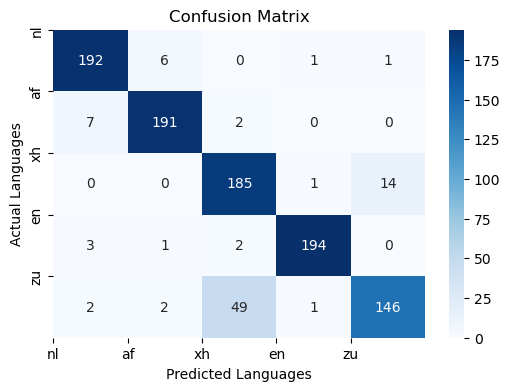

Language Identification Accuracy: 90.8%


In [146]:
# Define the language labels
language_labels = ['nl', 'af', 'xh', 'en','zu']

# Create confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=language_labels)

# Plot confusion matrix with color-coded values
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Languages')
plt.ylabel('Actual Languages')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(language_labels)), labels=language_labels)
plt.yticks(ticks=np.arange(len(language_labels)), labels=language_labels)
plt.show()
plt.show()

# Print language identification accuracy
print(f"Language Identification Accuracy: {accuracy:.1f}%")


This confusion matrix visually represents the classification results by comparing the predicted languages (rows) against the actual languages (columns).

$\bullet$  Diagonal cells (from top left to bottom right)  represent correctly classified instances and we can see that model well predicted more than 900 of instances.

$\bullet$ Off-diagonal cells indicate misclassifications or confusion between languages but we can see that the number of instances where the model predicted the language as Afrikaans (af) when it was actually Dutch is 6 and the opposite is 7. Also, the number of instances where the model predicted the language as Zulu (zu) when it was actually Xhosa(xh) is 14 and the opposite is 49. Only because theses languages are similar between them.

# 5) Byte-pair encoding for language similarity

## A) Token learner code for BPE from scratch

### a) Start by initializing the dataset with character vocabulary plus a special end of sentence symbol.

In [20]:
# Initialize vocabulary with unique characters and a special end-of-word symbol
def split_into_characters(sentence):
    characters = list(sentence)
    characters.append('</s>')  # Add end-of-sentence symbol
    return ' '.join(characters)  # Join characters into a single string with spaces

# Select a specific language to print the split sentences
selected_lang = 'en'

# Split sentences into characters for all languages
split_normalized_training_data = {}
for lang, df_normalized in normalized_training_data.items():
    df_characters = df_normalized['Sentence'].apply(split_into_characters)
    df_characters = pd.DataFrame({'Sentence': df_characters})
    split_normalized_training_data[lang] = df_characters

# Print the split sentences for the selected language
print(f"Language: {selected_lang}")
print(split_normalized_training_data[selected_lang])


Language: en
                                               Sentence
0            a c c e s s i b l e c o m p u t i n g </s>
1                                a n a r c h i s m </s>
2     a n a r c h i s m   i s   a   p o l i t i c a ...
3     a n a r c h i s m   c a l l s   f o r   t h e ...
4     a s   a   h i s t o r i c a l l y   l e f t w ...
...                                                 ...
5746  t h i s   i n c l u d e s   a u t o m a t e d ...
5747  0 d   a n i m a t i o n   h a s   m a n y   a ...
5748  c i n e m a g r a p h s   a r e   s t i l l   ...
5749  f i n a l   l i n e   a d v e c t i o n   a n ...
5750  s p e a k i n g   a b o u t   u s i n g   t h ...

[5751 rows x 1 columns]


This  code splits sentences into individual characters with an end-of-sentence symbol and organizes the split sentences by language in a dictionary.

### b) Then we count the frequency of each consecutive character pair in the dataset.

In [81]:
# Function to count the frequency of consecutive character pairs
def count_character_pairs(sentences):
    pair_counts = defaultdict(int)
    for sentence in sentences:
        characters = sentence.split()
        for i in range(len(characters) - 1):
            pair = (characters[i], characters[i+1])
            pair_counts[pair] += 1
    return pair_counts

# Select a specific language to count character pairs
selected_lang = 'en'

# Count character pairs for the selected language
pair_counts = count_character_pairs(split_normalized_training_data[selected_lang]['Sentence'])

# Print the pair counts vertically
print(f"Language: {selected_lang}")
for pair, count in pair_counts.items():
    print(f"Pair: {pair}  Count: {count}")

Language: en
Pair: ('a', 'c')  Count: 2722
Pair: ('c', 'c')  Count: 514
Pair: ('c', 'e')  Count: 2888
Pair: ('e', 's')  Count: 8192
Pair: ('s', 's')  Count: 2531
Pair: ('s', 'i')  Count: 3726
Pair: ('i', 'b')  Count: 527
Pair: ('b', 'l')  Count: 858
Pair: ('l', 'e')  Count: 4250
Pair: ('e', 'c')  Count: 3666
Pair: ('c', 'o')  Count: 4127
Pair: ('o', 'm')  Count: 2805
Pair: ('m', 'p')  Count: 1190
Pair: ('p', 'u')  Count: 622
Pair: ('u', 't')  Count: 1747
Pair: ('t', 'i')  Count: 8122
Pair: ('i', 'n')  Count: 11535
Pair: ('n', 'g')  Count: 4235
Pair: ('g', '</s>')  Count: 123
Pair: ('a', 'n')  Count: 10413
Pair: ('n', 'a')  Count: 4117
Pair: ('a', 'r')  Count: 6143
Pair: ('r', 'c')  Count: 1104
Pair: ('c', 'h')  Count: 3440
Pair: ('h', 'i')  Count: 4017
Pair: ('i', 's')  Count: 6237
Pair: ('s', 'm')  Count: 1262
Pair: ('m', '</s>')  Count: 235
Pair: ('m', 'i')  Count: 1824
Pair: ('s', 'a')  Count: 3766
Pair: ('a', 'p')  Count: 1191
Pair: ('p', 'o')  Count: 1901
Pair: ('o', 'l')  Count: 

The code defines a function, count_character_pairs(), which counts the frequency of consecutive character pairs in a list of sentences. It splits each sentence into individual characters and iterates through them, creating pairs of consecutive characters. Using these pairs as keys, it updates a dictionary that keeps track of the count for each pair. The function returns the resulting dictionary of pair counts. We then test it with the language 'en'. Down we also print the most_frequent_pair for this language and see that it's 't' and 'h' which confirms our result of the previous question in the excerpt of the language model for English, displaying all N-grams and their probability with the two-character history t h.

In [47]:
most_frequent_pair = max(pair_counts, key=pair_counts.get)
print(most_frequent_pair)

('t', 'h')


### c) We find the most frequent pair, and merge them together into a new token whenever we encounter them in the vocabulary: let's first start with one sentence before applying to the whole dataset.

In [79]:
# Function to merge the most frequent character pair in a sentence
def merge_most_frequent_pairs(sentence):
    pair_counts = count_character_pairs([sentence])
    if not pair_counts:
        return sentence
    most_frequent_pair = max(pair_counts, key=pair_counts.get)
    merged_token = ''.join(str(c) for c in most_frequent_pair)
    merged_sentence = sentence.replace(most_frequent_pair[0] + ' ' + most_frequent_pair[1], merged_token)
    return merged_sentence


# Select a specific language to print the split sentences
selected_lang = 'en'

# Select the split sentences for the selected language
selected_sentences = split_normalized_training_data[selected_lang]

# Convert the selected_sentences DataFrame column to a list
selected_sentences_list = selected_sentences['Sentence'].tolist()

# Select one sentence for demonstration
selected_sentence = selected_sentences_list[34]  # Access the first sentence

# Perform Byte Pair Encoding iteratively for one iteration
merged_sentence = merge_most_frequent_pairs(selected_sentence)
most_frequent_pair = max(count_character_pairs([merged_sentence]), key=count_character_pairs([merged_sentence]).get)

print("Original Sentence:")
print(selected_sentence)
print()
print('Merged Sentence:')
print(merged_sentence)

Original Sentence:
d u r i n g   t h e   p r e h i s t o r i c   e r a   o f   m a n k i n d   a n   e s t a b l i s h e d   a u t h o r i t y   d i d   n o t   e x i s t </s>

Merged Sentence:
d u ri n g   t h e   p r e h i s t o ri c   e r a   o f   m a n k i n d   a n   e s t a b l i s h e d   a u t h o ri t y   d i d   n o t   e x i s t </s>


This code defines a function, merge_most_frequent_pairs(), that takes a sentence as input. It first counts the frequency of consecutive character pairs in the sentence using the count_character_pairs() function. If there are no pair counts (i.e., the sentence has no consecutive character pairs), the function returns the original sentence. Otherwise, it identifies the most frequent pair by finding the pair with the highest count. It merges the characters of this most frequent pair into a single token. Then, it replaces the occurrences of the most frequent pair (separated by a space) in the sentence with the merged token. Finally, it returns the modified sentence.

We can see that in the merged sentence, the characters 'r' and 'i' are merged.

### d) This was only 1 iteration of the merging process, we can iteratively perform this merging step until 10 iterations for this sentence and visualize

In [80]:
# Select a specific language to print the split sentences
selected_lang = 'en'

# Select the split sentences for the selected language
selected_sentences = split_normalized_training_data[selected_lang]

# Convert the selected_sentences DataFrame column to a list
selected_sentences_list = selected_sentences['Sentence'].tolist()

# Select one sentence for demonstration
selected_sentence = selected_sentences_list[34]  # Access  sentence

print("Original Sentence:")
print(selected_sentence)
print()

# Perform Byte Pair Encoding iteratively for 10 iterations
for i in range(10):
    merged_sentence = merge_most_frequent_pairs(selected_sentence)
    most_frequent_pair = max(count_character_pairs([merged_sentence]), key=count_character_pairs([merged_sentence]).get)
    print(f"Iteration {i+1} - Merged Sentence:")
    print('Most Frequent Pair:',most_frequent_pair)
    print(merged_sentence)
    print()
    selected_sentence = merged_sentence

Original Sentence:
d u r i n g   t h e   p r e h i s t o r i c   e r a   o f   m a n k i n d   a n   e s t a b l i s h e d   a u t h o r i t y   d i d   n o t   e x i s t </s>

Iteration 1 - Merged Sentence:
Most Frequent Pair: ('i', 's')
d u ri n g   t h e   p r e h i s t o ri c   e r a   o f   m a n k i n d   a n   e s t a b l i s h e d   a u t h o ri t y   d i d   n o t   e x i s t </s>

Iteration 2 - Merged Sentence:
Most Frequent Pair: ('t', 'h')
d u ri n g   t h e   p r e h is t o ri c   e r a   o f   m a n k i n d   a n   e s t a b l is h e d   a u t h o ri t y   d i d   n o t   e x is t </s>

Iteration 3 - Merged Sentence:
Most Frequent Pair: ('is', 't')
d u ri n g   th e   p r e h is t o ri c   e r a   o f   m a n k i n d   a n   e s t a b l is h e d   a u th o ri t y   d i d   n o t   e x is t </s>

Iteration 4 - Merged Sentence:
Most Frequent Pair: ('o', 'ri')
d u ri n g   th e   p r e h ist o ri c   e r a   o f   m a n k i n d   a n   e s t a b l is h e d   a u th o ri t y 

Here we applied it for 10 iterations and we can see how at each iteration, we have a new most Frequent Pair depending on the one replaced in the sentence at the previous iteration. So the model is working properly for one sentence. Let's now apply it to the whole dataset.

## B) Apply BPE to each training set for 100 merge iterations

In [98]:
# Perform Byte Pair Encoding for each language in the list of DataFrames

def merge_most_frequent_pairs(sentences):
    pair_counts = count_character_pairs(sentences)
    if not pair_counts:
        return sentences
    most_frequent_pair = max(pair_counts, key=pair_counts.get)
    merged_token = ''.join(str(c) for c in most_frequent_pair)
    merged_sentences = [sentence.replace(most_frequent_pair[0] + ' ' + most_frequent_pair[1], 
                                         merged_token) for sentence in sentences]
    return merged_sentences

# Define the number of merge iterations
merge_iterations = 100

# Iterate over each language
for language in split_normalized_training_data.keys():
    
    # Select the split sentences column for the current language
    selected_sentences = split_normalized_training_data[language]['Sentence']

    # Convert the selected_sentences DataFrame column to a list
    selected_sentences_list = selected_sentences.tolist()

    
    for i in range(merge_iterations):
        merged_characters = set()
        # Perform merging on the sentences
        merged_sentences = merge_most_frequent_pairs(selected_sentences_list)

        # Count character pairs for the merged sentences
        pair_counts = count_character_pairs(merged_sentences)

        # Get the most frequent pair
        most_frequent_pair = max(pair_counts, key=pair_counts.get)


This is now the most important part: the code performs the repetitive merging process on split sentences for all languages. It iterates over each language's split sentences and for  100 iterations, merges the most frequent character pairs using the 'merge_most_frequent_pairs()' function. After each merge, it counts the frequency of consecutive character pairs in the merged sentences using the 'count_character_pairs()' function and identifies the most frequent pair. This process is repeated iteratively for 100 iterations.

### a) For each language, report which characters are merged in the first ten iterations

In [99]:
# Define the number of merge iterations
merge_iterations = 10

# Iterate over each language
for language, sentences in split_normalized_training_data.items():
    print(f"Language: {language}")
    print()

    # Convert the sentences column to a list
    sentences_list = sentences['Sentence'].tolist()

    # Merge sentences iteratively for 10 iterations
    for i in range(merge_iterations):
        # Perform merging on the sentences
        merged_sentences = merge_most_frequent_pairs(sentences_list)

        # Count character pairs for the merged sentences
        pair_counts = count_character_pairs(merged_sentences)

        # Get the most frequent pair
        most_frequent_pair = max(pair_counts, key=pair_counts.get)

        # Report the most frequent pair for each iteration
        print(f"Iteration {i+1} - Most Frequent Pair: {most_frequent_pair}")
        print()

        # Update sentences list with merged sentences
        sentences_list = merged_sentences

    print()


Language: af

Iteration 1 - Most Frequent Pair: ('e', 'r')

Iteration 2 - Most Frequent Pair: ('a', 'n')

Iteration 3 - Most Frequent Pair: ('e', 'n')

Iteration 4 - Most Frequent Pair: ('d', 'ie')

Iteration 5 - Most Frequent Pair: ('i', 'n')

Iteration 6 - Most Frequent Pair: ('0', '0')

Iteration 7 - Most Frequent Pair: ('e', 'l')

Iteration 8 - Most Frequent Pair: ('s', 't')

Iteration 9 - Most Frequent Pair: ('s', 'e')

Iteration 10 - Most Frequent Pair: ('o', 'o')


Language: nl

Iteration 1 - Most Frequent Pair: ('e', 'r')

Iteration 2 - Most Frequent Pair: ('d', 'e')

Iteration 3 - Most Frequent Pair: ('a', 'n')

Iteration 4 - Most Frequent Pair: ('i', 'n')

Iteration 5 - Most Frequent Pair: ('e', 't')

Iteration 6 - Most Frequent Pair: ('s', 't')

Iteration 7 - Most Frequent Pair: ('e', 'l')

Iteration 8 - Most Frequent Pair: ('i', 'j')

Iteration 9 - Most Frequent Pair: ('o', 'r')

Iteration 10 - Most Frequent Pair: ('0', '0')


Language: en

Iteration 1 - Most Frequent Pair:

The output of this code consists of information about the most frequent character pair obtained in each iteration for each language. The code then reports the most frequent character pair for each iteration, displaying the iteration number and the most frequent pair. After reporting the most frequent pair, the code updates the sentences list with the merged sentences.

Once the merging process is complete for a language, it moves to the next language and repeats the process. So the output is a series of sections for each language, showing the most frequent pair obtained in each iteration of the merging process.

### b) Overlap of the BPE subword vocabulary between each of the languages.

In [126]:
# Initialize a dictionary to store the overlapping subword vocabulary counts
overlap_counts = {}

# Iterate over each pair of languages
for lang1, sentences1 in split_normalized_training_data.items():
    for lang2, sentences2 in split_normalized_training_data.items():
        if lang1 != lang2:  # Exclude self-comparison
            # Convert the sentences columns to lists
            sentences_list1 = sentences1['Sentence'].tolist()
            sentences_list2 = sentences2['Sentence'].tolist()

            # Merge subwords iteratively for a few iterations
            merge_iterations = 10
            for i in range(merge_iterations):
                merged_sentences1 = merge_most_frequent_pairs(sentences_list1)
                merged_sentences2 = merge_most_frequent_pairs(sentences_list2)

                # Create sets of subword tokens for each language
                subwords1 = set(''.join(merged_sentences1).split())
                subwords2 = set(''.join(merged_sentences2).split())

                # Calculate the overlap of subword tokens
                overlap = len(subwords1.intersection(subwords2))*0.1

                # Update the overlap counts dictionary
                key = f'{lang1}-{lang2}'
                if key not in overlap_counts:
                    overlap_counts[key] = 0
                overlap_counts[key] += overlap

                # Update sentences lists with merged sentences
                sentences_list1 = merged_sentences1
                sentences_list2 = merged_sentences2

# Print the overlap counts for each language pair
# Print the overlap percentages for each language pair
for languages, overlap in overlap_counts.items():
    lang1, lang2 = languages.split('-')
    overlap_percentage = overlap   
    print(f"Overlap between {lang1} and {lang2}: {overlap_percentage:.2f}%")


Overlap between af and nl: 66.70%
Overlap between af and en: 58.00%
Overlap between af and xh: 68.50%
Overlap between af and zu: 69.40%
Overlap between nl and af: 66.70%
Overlap between nl and en: 59.00%
Overlap between nl and xh: 67.70%
Overlap between nl and zu: 67.00%
Overlap between en and af: 58.00%
Overlap between en and nl: 59.00%
Overlap between en and xh: 60.50%
Overlap between en and zu: 61.40%
Overlap between xh and af: 68.50%
Overlap between xh and nl: 67.70%
Overlap between xh and en: 60.50%
Overlap between xh and zu: 82.00%
Overlap between zu and af: 69.40%
Overlap between zu and nl: 67.00%
Overlap between zu and en: 61.40%
Overlap between zu and xh: 82.00%


The output shows the overlap percentages between the subword vocabularies of different language pairs using the Byte Pair Encoding (BPE) technique. The percentages indicate the level of shared subwords between the languages.

We already know that the overlap between same langauges are 100% so we just print the one between different languages.

The results indicate that there is some degree of overlap in subword vocabularies between the language pairs. The percentages range from around 58% to 82%, suggesting varying levels of similarity in subword structures among the languages. For example, the pairs 'af' (Afrikaans) and 'nl' (Dutch) have a 66.7% overlap, indicating a significant shared subword vocabulary. Similarly, 'af' and 'xh' (Xhosa) have a higher overlap of 68.5%, while 'af' and 'zu' (Zulu) have a 69.4% overlap, suggesting a relatively closer subword resemblance.

The highest overlap is observed between 'xh' and 'zu', with an 82.0% overlap. This suggests a strong similarity in subword structures between Xhosa and Zulu.

We know that there are some similarities between some language such that Afrikaans(af) and Dutch(nl) and also Xhosa(xh) band Zulu(zu). So we expect to have high overlap between these language. As we saw before, the overlap between theses languages are respectively 66.7% and 82.0% , which are higher. So it matchs our expectations. 